## ДЗ8

1. Реализовать метрики: Precision@k, Recall@k, mAP 
2. Добавить train аугментации (добавлены RandomAffine и RandomPerspective)
3. Обучить модель,
  * При обучении использовать backbone отличный от того, что использовался на семинаре (densenet161)
  *  Добавить triplet-loss (реализован датасет TripletCarsDataset и TripletLoss)
4. Рассчитать метрики из п.1
5. Показать с помощью град Кама, где ошибается модель

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import scipy.io

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Работа с данными

In [3]:
TRAIN_ANNOTS_PATH = '/kaggle/input/hw8-cars196/devkit/devkit/cars_train_annos.mat'
CARS_META_PATH =  '/kaggle/input/hw8-cars196/devkit/devkit/cars_meta.mat'
ADD_PATH = '/kaggle/input/hw8-cars196/archive/cars_train/cars_train'

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    DEVICE="cuda"
    print("Use CUDA")
else:
    DEVICE="cpu"

Use CUDA


In [4]:
mat = scipy.io.loadmat(TRAIN_ANNOTS_PATH)
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat(CARS_META_PATH)
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

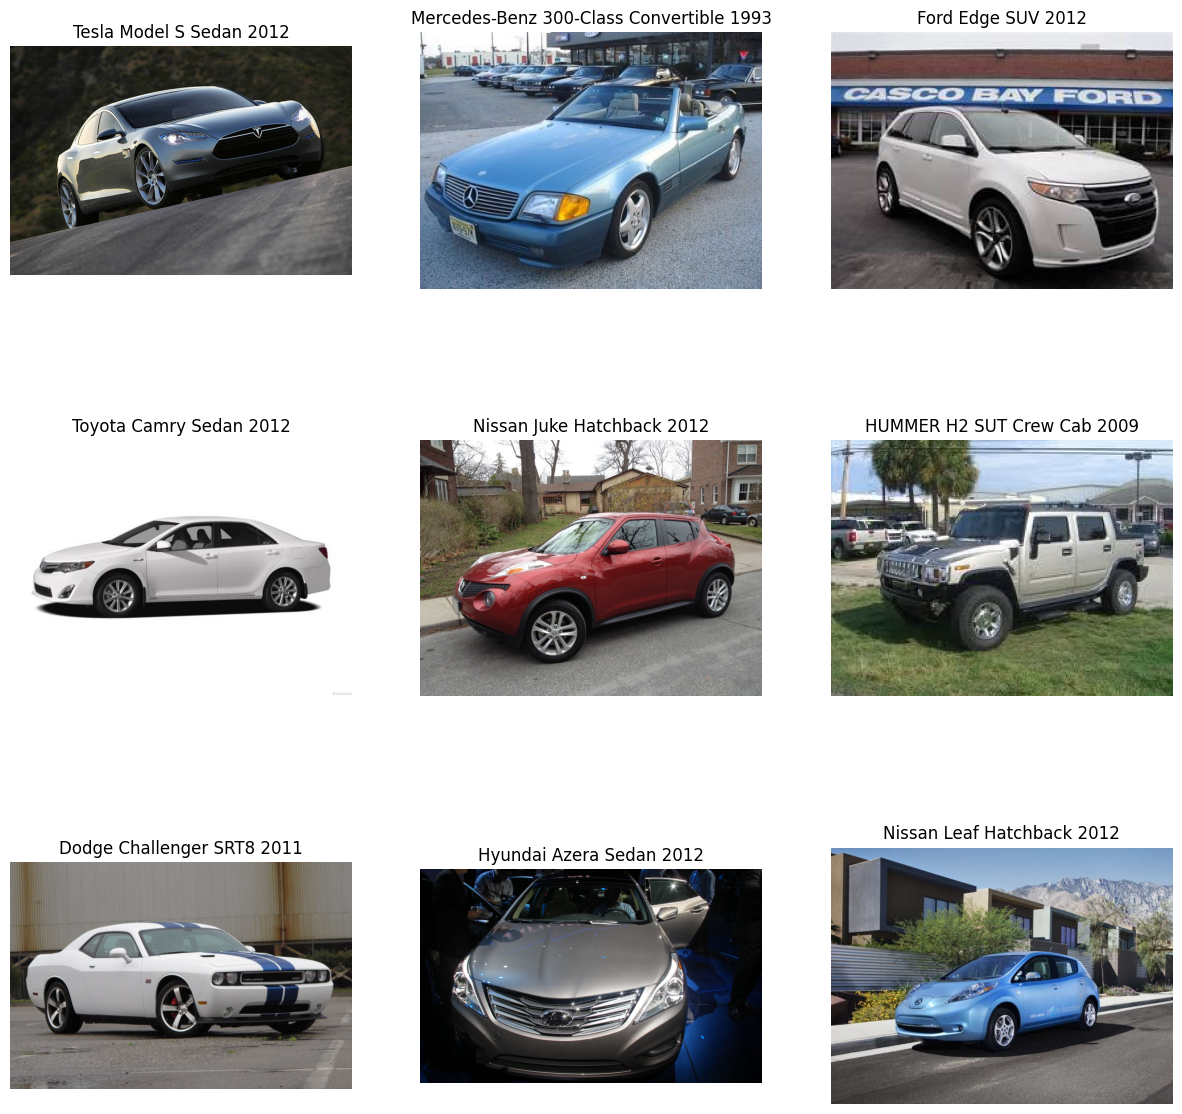

In [5]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

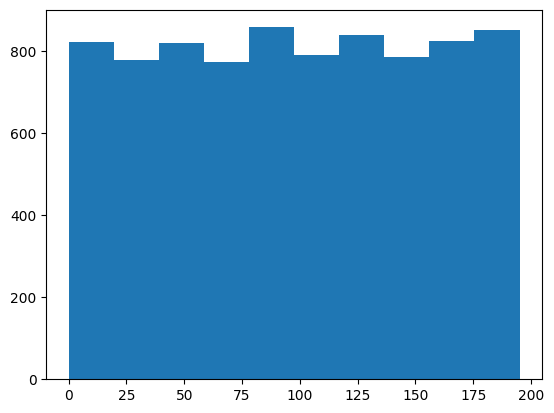

In [6]:
plt.hist(fname_to_class.values())
plt.show()

In [7]:
items = list(fname_to_class.items())
random.shuffle(items)

train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_imgs = np.array([item[0] for item in train_items])
train_ids = np.array([item[1] for item in train_items])

val_imgs = np.array([item[0] for item in val_items])
val_ids = np.array([item[1] for item in val_items])

 # Реализация датасета TripletCarsDataset с mining'ом для TripletLoss

если TripletCarsDataset не принимает модель в конструкторе, то негативный объект представлен любым объектом, без учета расстояния между позитивным объектом и якорным

In [8]:
MARGIN = 0.2

def get_square_of_distance(x1, x2):
    return (x1 - x2).pow(2).sum(1).to('cpu')

class TripletCarsDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, ids, transforms, model=None, triplet_mining_transforms=None, triplet_mining_type='hard', triplet_margin=MARGIN):
        """
        Class for batch formation for CarEmbedder's use.
        If there is a transforms, images for batch are transformed.
        If there is the model different types of mining are used.
        
        Args:
            imgs: images from CAR196.
            ids: ids from CAR196.
            transforms: transforms for images at the time of batch formation.
            model: model for calculation of embeddings for triplet-batch mining.
            triplet_mining_type: type for triplet-batch mining: 'hard', 'semi-hard' or 'easy'.
            triplet_margin: margin for triplet-batch mining.
        """
        self.cars = np.vstack([imgs, ids])
        self.transforms = transforms
        self.model = model
        if model:
            if triplet_mining_transforms is None:
                raise RuntimeError('triplet_mining_transform must be trasform, not None')
            if triplet_mining_type not in ('hard', 'semi-hard', 'easy'):
                raise RuntimeError('triplet_mining_type must be "hard", "semi-hard" or "easy"')
            self.mining_type = triplet_mining_type
            self.margin = triplet_margin
        
    def __len__(self):
        return self.cars.shape[1]
    
    def _get_positive(self, anchor_id, anchor_filename):
        """
        Find positive instance for triplet-batch mining.
        
        Args:
            anchor_id: anchor's class id.
            anchor_filename: anchor's image filename.
        """
        # first index erase objects with not same class, second - erase anchor object
        positives = self.cars[:, self.cars[1] == anchor_id]
        positives = positives[:, positives[0] != anchor_filename]
        
        # bcs there are case with only one image in class in val_data
        if positives.shape[1]:
            random_idx = random.randint(0, positives.shape[1] - 1)
            return positives[0, random_idx], positives[1, random_idx]
        
        return 'error', 0
        
    
    def _get_negative(self, anchor_id, anchor_embedding=None, positive_embedding=None):      
        """
        Find negative instance for triplet-batch mining.
        If there is the model different types of mining are used.
        
        Args:
            anchor_id: anchor's class id.
            anchor_embedding: anchor's embedding with shape (feat_dim).
            positive_embedding: positive embedding with shape (feat_dim).
        """
        negatives = self.cars[:, self.cars[1] != anchor_id]
        if self.model is None:
            random_idx = random.randint(0, negatives.shape[1] - 1)
            return negatives[0, random_idx], negatives[1, random_idx]
        
        dist_anchor_to_positive = get_square_of_distance(anchor_embedding, positive_embedding)
        i = 0
        while True:
            # check if no one item don't pass picked mining_type 
            if (i == negatives.shape[1]):
                random_idx = random.randint(0, negatives.shape[1] - 1)
                return negatives[0, random_idx], negatives[1, random_idx]
            
            i = i + 1
            random_idx = random.randint(0, negatives.shape[1] - 1)
            negative_filename = negatives[0, random_idx]
            negative_id = negatives[1, random_idx]
            
            negative_image = cv2.imread(os.path.join(ADD_PATH, negative_filename))
            negative_image = cv2.cvtColor(negative_image, cv2.COLOR_BGR2RGB)
            
            with torch.no_grad():
                negative_embedding = self.model(triplet_mining_transforms(negative_image).to(DEVICE))
            dist_anchor_to_negative = get_square_of_distance(anchor_embedding, negative_embedding)
                        
            if self.mining_type == 'hard' and dist_anchor_to_negative < dist_anchor_to_positive or \
               self.mining_type == 'semi-hard' and dist_anchor_to_positive < dist_anchor_to_negative < dist_anchor_to_positive + self.margin or \
               self.mining_type == 'easy' and dist_anchor_to_negative > dist_anchor_to_positive + self.margin:
                return negative_filename, negative_id
            
    def __getitem__(self, idx):
        anchor_filename, anchor_id = self.cars[0, idx], self.cars[1, idx]
        anchor_image = cv2.imread(os.path.join(ADD_PATH, anchor_filename))
        anchor_image = cv2.cvtColor(anchor_image, cv2.COLOR_BGR2RGB)
        
        positive_filename = self._get_positive(anchor_id, anchor_filename)[0]
        
        # bcs there are case with only one image in class in val_data
        if positive_filename == 'error':
            positive_image = anchor_image
        else:
            positive_image = cv2.imread(os.path.join(ADD_PATH, positive_filename))
            positive_image = cv2.cvtColor(positive_image, cv2.COLOR_BGR2RGB)
        
        if self.model is None:
            negative_filename = self._get_negative(anchor_id)[0]
        else:
            self.model.eval()
            
            with torch.no_grad():
                anchor_embedding = self.model(triplet_mining_transforms(anchor_image).to(DEVICE))
                positive_embedding = self.model(triplet_mining_transforms(positive_image).to(DEVICE))
            
            negative_filename = self._get_negative(anchor_id, anchor_embedding, positive_embedding)[0]
            
            self.model.train()
        
        negative_image = cv2.imread(os.path.join(ADD_PATH, negative_filename))
        negative_image = cv2.cvtColor(negative_image, cv2.COLOR_BGR2RGB) 
        
        if self.transforms:
            anchor_image = self.transforms(anchor_image)
            positive_image = self.transforms(positive_image)
            negative_image = self.transforms(negative_image)
            
        return {'anchor_image': anchor_image, 'positive_image': positive_image, 'negative_image': negative_image}

так же определим CropClassifDataset, используемый на семинаре, чтобы потом его использовать для поиска похожих ембеддингов машин

In [9]:
class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, ids, transforms):
        self.cars = np.vstack([imgs, ids])
        self.transforms = transforms
        
    def __len__(self):
        return self.cars.shape[1]

    def __getitem__(self, idx):
        filename, cl_id = self.cars[:, idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

# Реализация TripletLoss

In [10]:
def get_square_of_distance(x1, x2):
    return (x1 - x2).pow(2).sum(1).to('cpu')

class TripletLoss(nn.Module):
    def __init__(self, margin=MARGIN):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        """
        Args:
            anchor: anchor embeddings with shape (batch_size, feat_dim).
            positive: positive embeddings with shape (batch_size, feat_dim).
            negative: negative embeddings with shape (batch_size, feat_dim).
        """
        batch_size = anchor.size(0)
        
        dist_anchor_to_negative = get_square_of_distance(anchor, negative)
        dist_anchor_to_positive = get_square_of_distance(anchor, positive)
        
        value = dist_anchor_to_positive - dist_anchor_to_negative + self.margin
        
        loss = 1. / 2. * torch.max(torch.zeros_like(value), value)
        
        return loss

# Реализация CarEmbedder, использующего TripletLoss

In [11]:
import gc

In [12]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from torchvision.models import densenet161, resnet50

class CarEmbedder(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size, triplet_margin=MARGIN):
        super().__init__()
        self.learning_rate = learning_rate
        
        self.model = densenet161(pretrained=True)
        self.model.classifier = torch.nn.Sequential(
                            torch.nn.Linear(in_features=2208, out_features=emb_size))

        self.triplet_loss = TripletLoss(triplet_margin)

        self.save_hyperparameters()
        
    def training_step(self, batch, batch_idx):
        gc.collect()
        anchor_imgs = batch['anchor_image']
        positive_imgs = batch['positive_image']
        negative_imgs = batch['negative_image']
        
        anchor_emb = self.model(anchor_imgs)
        
        self.model.eval()
        with torch.no_grad():
            positive_emb = self.model(positive_imgs)
            negative_emb = self.model(negative_imgs)
        
        self.model.train()
        
        loss = self.triplet_loss(anchor_emb, positive_emb, negative_emb).mean()
        
        self.log("train_loss", loss.mean(), sync_dist=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        gc.collect()
        anchor_imgs = batch['anchor_image']
        positive_imgs = batch['positive_image']
        negative_imgs = batch['negative_image']
        
        anchor_emb = self.model(anchor_imgs)
        positive_emb = self.model(positive_imgs)
        negative_emb = self.model(negative_imgs)
        
        loss = self.triplet_loss(anchor_emb, positive_emb, negative_emb).mean()
        
        self.log("val_loss", loss, sync_dist=True)
        
        
    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images) 
        else:
            preds = self.model(images.unsqueeze(0))
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

# Обучение

In [13]:
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1)),
            torchvision.transforms.RandomPerspective(distortion_scale=0.2),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])


val_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

triplet_mining_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

Проверим, правильно ли работает датасет

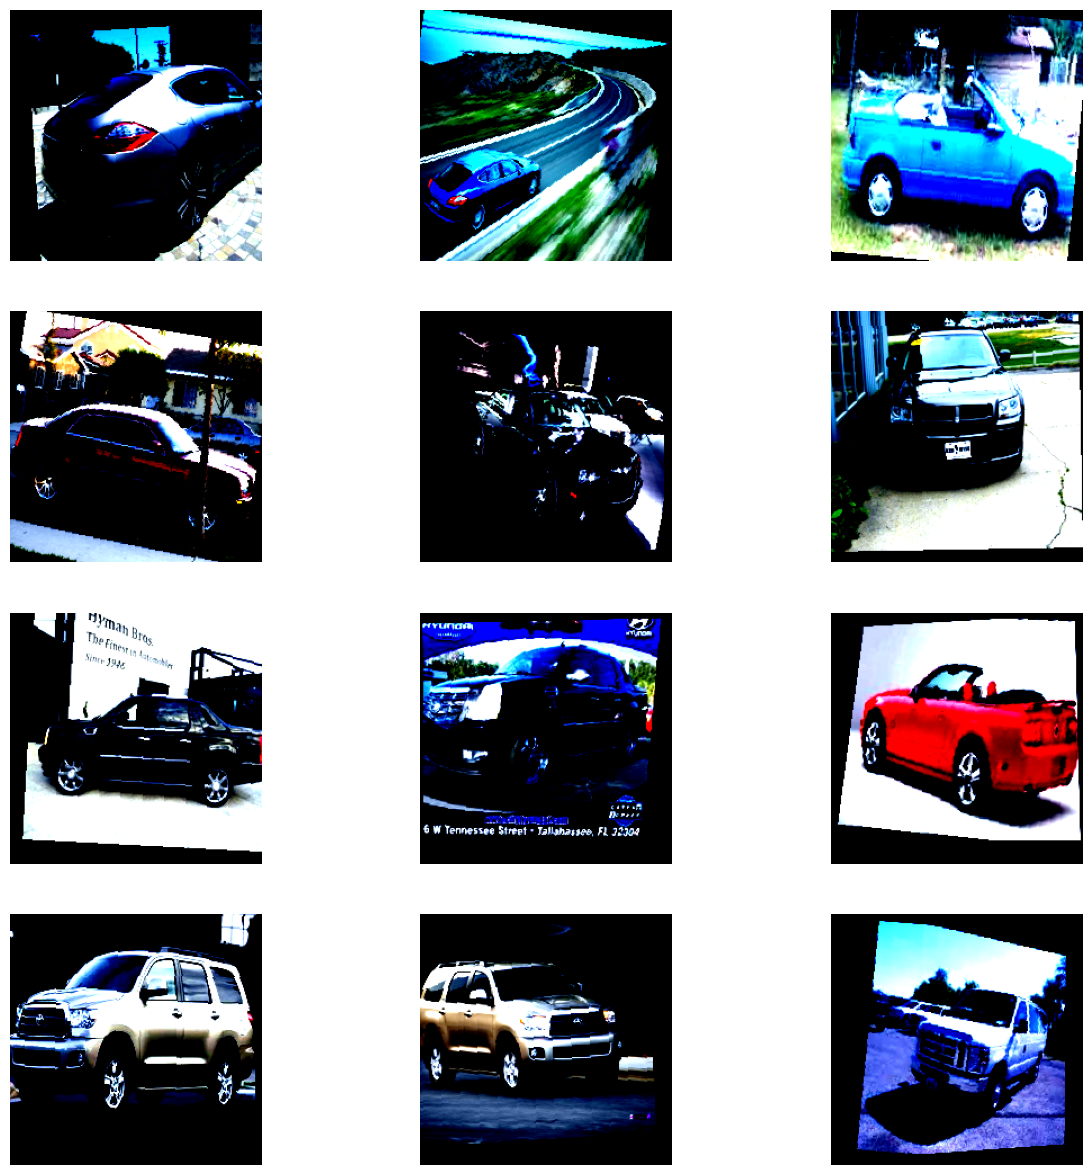

In [14]:
train_dataset = TripletCarsDataset(train_imgs, train_ids, train_transforms)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)

batch = next(iter(train_loader))

cols = 3
rows = 4
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx in range(rows):
    anchor = batch['anchor_image'][idx]
    positive = batch['positive_image'][idx]
    negative =  batch['negative_image'][idx]
    
    ax[idx][0].imshow(anchor.permute(1, 2, 0).numpy())
    ax[idx][0].axis('off')
    
    ax[idx][1].imshow(positive.permute(1, 2, 0).numpy())
    ax[idx][1].axis('off')
    
    ax[idx][2].imshow(negative.permute(1, 2, 0).numpy())
    ax[idx][2].axis('off')

Если использовать в train_dataset num_workers, то будет исключение "RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method". Но так будет очень долго обучаться, поэтому я использовал TripletCarsDataset без модели, то есть просто обучал нейронку разделять классы без учета расстояния между якорным объектом и позитивным объектом

In [72]:
EPOCHS = 2

pl_model = CarEmbedder(id_to_car, 3e-4, 512, MARGIN)
pl_model.to(DEVICE)
pl_model.train()

# используем специальный датасет для TripletLoss
val_dataset = TripletCarsDataset(val_imgs, val_ids, val_transforms)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=None, num_workers=8, pin_memory=True)

for _ in range(EPOCHS):
    train_dataset = TripletCarsDataset(train_imgs, train_ids, train_transforms)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, collate_fn=None, pin_memory=True, drop_last = True)

    trainer = pl.Trainer(max_epochs = 1, accelerator=DEVICE)
    trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [73]:
trainer.validate(model=pl_model, dataloaders=val_loader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.14361010491847992    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.14361010491847992}]

## Реализация Precision@k, Recall@k, mAP

In [74]:
def precision_k(labels, embeds, index, k):
    Distances, Indexes = index.search(embeds, k)
    
    predicted_labels = train_labels[Indexes.flatten()]
    return np.sum([labels[i] in predicted_labels[i * k : (i+1) * k] for i in range(labels.shape[0])]) / (labels.shape[0] * k)

In [75]:
def recall_k(labels, embeds, index, k):
    Distances, Indexes = index.search(embeds, k)
    
    predicted_labels = train_labels[Indexes.flatten()]
    return np.sum([labels[i] in predicted_labels[i * k : (i+1) * k] for i in range(labels.shape[0])]) / labels.shape[0]

# Поиск похожих машин

In [76]:
# используем датасет, определенный в семинаре
train_dataset = CropClassifDataset(train_imgs, train_ids, val_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)

val_dataset = CropClassifDataset(val_imgs, val_ids, val_transforms)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

In [77]:
def get_embeds(model, loader):
    embeddings = np.empty((1,512))
    labels = np.empty((1))
    for batch in tqdm.tqdm_notebook(loader):
        
        imgs = batch['image']
        label = batch['label']
        
        pl_model.to(DEVICE)
        with torch.no_grad():
            preds = model(imgs.to(DEVICE))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, np.array(label)])
    
    return embeddings[1:].astype(np.float32), labels[1:]

In [78]:
pl_model.eval()

train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, val_loader)

/tmp/ipykernel_32/1155310784.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm.tqdm_notebook(loader):


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [79]:
!pip install faiss-gpu

In [80]:
import faiss     

index = faiss.IndexFlatL2(512)   
index.add(train_emb)                  

In [81]:
k = 10

print(f'Recall @ {k} : {recall_k(val_labels, val_emb, index, k)}')
print(f'Precision @ {k} : {precision_k(val_labels, val_emb, index, k)}')

Recall @ 10 : 0.15224063842848373
Precision @ 10 : 0.015224063842848374


# GradCam with embeds

In [82]:
!pip install grad_cam

In [83]:
from PIL import Image
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

1. Находим ошибки модели
2. Получаем на каких эмбеддингах, картинках и метках была ошибка
3. Получаем картинку того же класса, что в п.2
4. Строим GradCam

1. Находим ошибки модели


In [84]:
Distances, Indexes = index.search(val_emb, k)
    
predicted_labels = train_labels[Indexes.flatten()]
prediction_result = [val_labels[i] in predicted_labels[i * k : (i+1) * k] for i in range(val_labels.shape[0])]

prediction_result[:10]

[False, False, False, False, False, False, False, False, True, False]

2. Получаем на каких эмбеддингах, картинках и метках была ошибка

In [85]:
# bcs for val_loader shuffle=False, we can check data from this loader
val_cars_concept_features = np.empty((1, 512))
val_cars_imgs = np.empty((1, 224, 224, 3))
val_cars_label = np.empty((1))

# save embeddings with error model's prediction from first prediction
batch = next(iter(val_loader))

imgs = batch['image']
labels = batch['label']
for i, (img, label) in enumerate(zip(imgs, labels)):
    if not prediction_result[i]:
        img_tensor = img.unsqueeze(0)
        img_float = img_tensor.clamp(0,1).cpu().permute(0, 2, 3, 1).numpy()

        with torch.no_grad():
            preds = pl_model(img_tensor.to(DEVICE))

        val_cars_concept_features = np.concatenate([val_cars_concept_features, preds.cpu().numpy()])
        val_cars_imgs = np.concatenate([val_cars_imgs, img_float])
        val_cars_label = np.concatenate([val_cars_label, np.array([label])])
            
val_cars_concept_features = val_cars_concept_features[1:]
val_cars_imgs = val_cars_imgs[1:]
val_cars_label = val_cars_label[1:]

3. Получаем картинку того же класса, что в п.2

In [86]:
def get_same_class_image(data, label, transforms):
    same_class_objects = data[:, data[1, :] == label]
    random_idx = random.randint(0, same_class_objects.shape[1] - 1)
    filename = same_class_objects[0, random_idx]
    
    image = cv2.imread(os.path.join(ADD_PATH, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    tensor = transforms(image)

    return tensor.unsqueeze(0)

4. Строим GradCam

In [87]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
    
class DifferenceFromConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return 1 - cos(model_output, self.features)

In [88]:
def show_grad_cam(concept_features, image, label):
    #same_class_tensor, same_class_image = get_same_class_image(train_dataset.cars, label, val_transforms)
    same_class_tensor = get_same_class_image(train_dataset.cars, label, val_transforms)

    target_layers = [pl_model.model.features.denseblock4.denselayer24]
    car_targets = [DifferenceFromConceptTarget(torch.Tensor(concept_features).to(DEVICE))]

    with GradCAM(model=pl_model.model,
                 target_layers=target_layers,
                 use_cuda=False) as cam:
        car_grayscale_cam = cam(input_tensor=same_class_tensor.to(DEVICE), targets=car_targets)[0, :]

    car_cam_image = show_cam_on_image(image, car_grayscale_cam, use_rgb=True)
    plt.imshow(car_cam_image)
    plt.show()

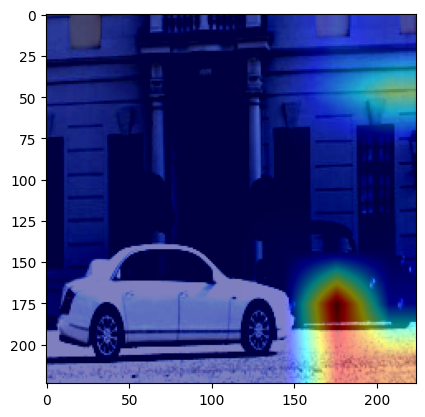

In [89]:
show_grad_cam(val_cars_concept_features[0], val_cars_imgs[0], val_cars_label[0])

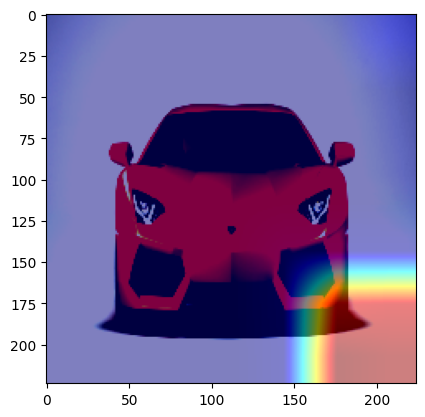

In [90]:
show_grad_cam(val_cars_concept_features[1], val_cars_imgs[1], val_cars_label[1])

Как видно, модель не смогла обучиться правильно строить эмбеддинги для разных марок машин. Возможно, есть какая-то ошибка в реализации tripletLoss, или стоило использовать более большие батчи. Я пытался использовать разные margin, разное количество эпох, но результат не улучшаться. Более большие батчи я не мог использовать, так как в этом случае возникала ошибка связанная с тем, что видеопамяти не хватает